In [1]:
import tensorflow as tf
import numpy as Np
import matplotlib.pyplot as plt

allData = Np.loadtxt("/home/oleksandr/eye_tracking/indata15.csv", delimiter = ';', skiprows = 1)
allData[1,:]
allData[:,0] = allData[:,0]*2-1

nobs, nfts = allData.shape
nfts = nfts - 1

print 'Observations: {}, Features : {}'.format(nobs, nfts)

Observations: 10371, Features : 40


In [13]:
n_control = nobs //10
cset = range(n_control)
lset = range(n_control, nobs)
features = range(1, nfts + 1)
X_train = allData[Np.ix_(lset, features)]
Y_train = allData[lset, 0].reshape((nobs-n_control,1))
X_test = allData[Np.ix_(cset, features)]
Y_test = allData[cset, 0].reshape((n_control,1))


In [14]:
Y_train.shape

(9334, 1)

In [27]:
#TensorFlow

X = tf.placeholder("float", [None, nfts]) #Вход

layerOneN = 10
layerOneW = tf.Variable(tf.random_normal([nfts, layerOneN], stddev = 1.0)) #Входные веса нейронов 1 слоя
layerOneB = tf.Variable(tf.random_normal([1], stddev = 1.0)) #Базис  нейронов 1 слоя



layerOutW = tf.Variable(tf.random_normal([layerOneN, nfts], stddev = 1.0e-1)) #Входные веса нейронов 2го слоя
layerOutB = tf.Variable(tf.random_normal([1], stddev = 1.0e-1)) #Базис  нейронов 2го слоя

#Работа сети
layerOneAct =  tf.sigmoid(tf.matmul(X,layerOneW)+layerOneB)
layerOneResult = tf.cast(tf.greater(layerOneAct, 0.5), tf.float32)
layerOutAct = tf.matmul(layerOneResult, layerOutW)+layerOutB
layerOutResult = layerOutAct#tf.cast(tf.greater(layerOutAct, 0.5), tf.float32)

#Функция цены RMS
rho = tf.constant(2.0/layerOneN) #Параметр регуляризации rho
beta = tf.constant(5.0)# --"-- beta
lam  = tf.constant(1.0e-3) #--""-- lambda
rho_hat = tf.reduce_mean(layerOneAct,0)

J  = tf.reduce_mean(tf.reduce_sum(tf.pow(layerOutResult - X, 2),1)) # RMS  
L2 = tf.reduce_sum(layerOneW**2) + tf.reduce_sum(layerOutW**2)#L2 регуляризация
#L1 = tf.reduce_sum(tf.abs(layerOneW))+tf.reduce_sum(tf.abs(layerOutW))
KL = rho*tf.log(rho/rho_hat)+(1-rho)*tf.log((1-rho)/(1-rho_hat)) 
cost_fun = J + beta*tf.reduce_sum(KL)+lam*L2#

#Оптимизатор
opt = tf.train.AdamOptimizer(0.001).minimize(cost_fun)


Start cost: 12.1733140945
Final cost: 1.70067179203
[ 0.19998203  0.1999357   0.20003805  0.20623757  0.20003532  0.20005926
  0.21473137  0.20904297  0.19987623  0.20002225]


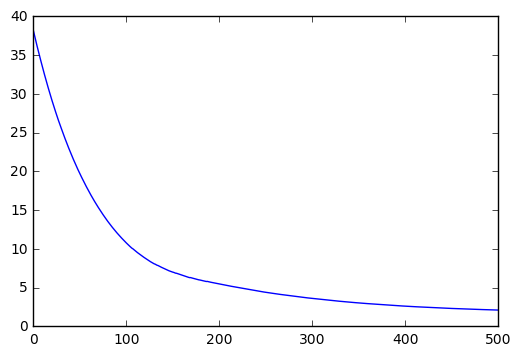

In [28]:
#Jбучение

sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)


#А теперь поехали:
cost_progress = []
num_epochs = 500
print 'Start cost: {}'.format(sess.run(J, feed_dict={X:X_train}))
for i in range(num_epochs):   
    sess.run(opt, feed_dict={X:X_train})
    cost_progress.append(sess.run(cost_fun, feed_dict={X:X_train})) 
print 'Final cost: {}'.format(sess.run(J, feed_dict={X:X_train}))
print sess.run(rho_hat, feed_dict={X:X_train})
plt.plot(cost_progress)
plt.show()
out_layer_w = sess.run(layerOutW)
out_layer_b = sess.run(layerOutB)

In [29]:
out_layer_w

array([[ 0.08503164,  0.14120618, -0.00480956,  0.08076732,  0.09428818,
         0.14874072, -0.02222214,  0.11442872,  0.03001436,  0.14714569,
        -0.05377292, -0.03725739,  0.01391485, -0.09212814, -0.01243558,
         0.02818949, -0.0557386 , -0.00953231,  0.07243574,  0.08232607,
         0.0951546 ,  0.08181114,  0.059102  ,  0.19545403,  0.0571921 ,
         0.08427199,  0.16505915,  0.11497128,  0.03520487,  0.11077171,
         0.01063407, -0.11414828,  0.01996153,  0.15679505, -0.12156627,
        -0.11983979, -0.12065838, -0.04088522, -0.07416113,  0.07702871],
       [ 0.00969769,  0.09092291, -0.00726478,  0.12113834,  0.07670188,
         0.13352163, -0.09223886,  0.19902967,  0.24579072,  0.03998788,
         0.10064101,  0.05942288, -0.00487028,  0.06507901,  0.10245845,
        -0.01544396, -0.01580273,  0.14278416,  0.14444637,  0.08947091,
        -0.03770171,  0.00889513,  0.0301735 ,  0.06625187,  0.20565392,
         0.08397017,  0.19786538,  0.07060614,  0.

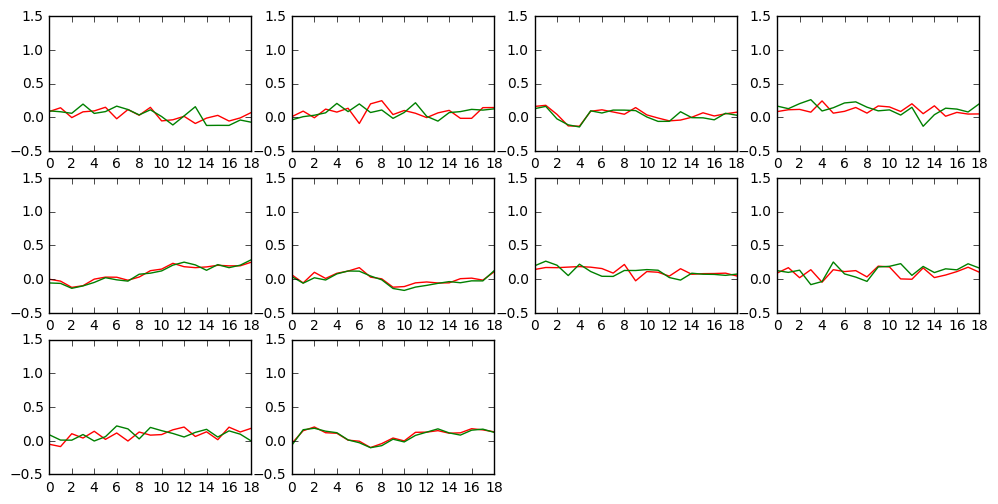

In [30]:
import math

fig_size = math.ceil(math.sqrt(layerOneN))

plt.figure(figsize=(12,8))
for i in range(layerOneN):
    plt.subplot(fig_size, fig_size, i+1)
    plt.plot(out_layer_w[i, 0:19], 'r')
    plt.plot(out_layer_w[i,20:39], 'g')
    plt.ylim(-0.5,1.5)
plt.show()

In [31]:
sess.run(L2, feed_dict={X:X_train})

411.23636

In [32]:
print(sess.run(J, feed_dict={X:X_test}))

1.80461


In [22]:
J

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [289]:
cost_progress[:50]

[63.882545,
 52.832035,
 43.23991,
 35.188019,
 28.547596,
 23.146957,
 18.808739,
 15.361719,
 12.64869,
 10.531351,
 8.891242,
 7.6294436,
 6.6647615,
 5.9313555,
 5.3764682,
 4.9581594,
 4.6432595,
 4.4057636,
 4.2252822,
 4.0859914,
 3.9756756,
 3.884948,
 3.8066704,
 3.7355011,
 3.6674871,
 3.5998113,
 3.5304978,
 3.4582736,
 3.3823938,
 3.3025172,
 3.2186499,
 3.1310236,
 3.0400884,
 2.9463928,
 2.8505869,
 2.7533939,
 2.6555641,
 2.5578396,
 2.4610012,
 2.3657429,
 2.2727542,
 2.182667,
 2.0960269,
 2.0133417,
 1.9350244,
 1.8614112,
 1.7927591,
 1.7292308,
 1.6709263,
 1.6178519]

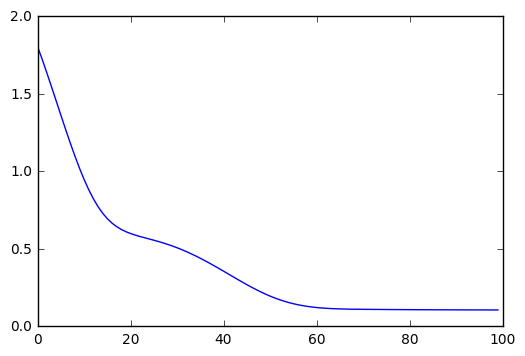

In [296]:
plt.plot(Np.log10(Np.array(cost_progress[:100])))
plt.show()

In [292]:
sess.run

TypeError: return arrays must be of ArrayType